## ECG PROCESSING 

In [62]:
from biosppy import storage
from biosppy.signals import ecg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modwt import modwt, modwtmra
import os

### 1. Correct the errors in the raw CSV files 

In [133]:
def fix_broken_csv(file_path):
    rf = open (file_path, 'r')
    ff = open(file_path.replace('.csv','fixed.csv' ), 'w')
    line = rf.readline()
    ff.write(line)
    while line:
        line = rf.readline()
        line = line.replace(',AMEER','')
        line = line.replace(',j',',0')
        if "03:51:35.125749,52303:52:33.684308,664" in line:
            ff.write("03:51:35.125749,523\n")
            ff.write("03:52:33.684308,664\n")   
        else:
            ff.write(line)
    rf.close()
    ff.close()
    os.system("mv " + file_path.replace('.csv','fixed.csv' ) + " " + file_path)

In [134]:
fix_broken_csv('data/gamer4-ppg-2000-01-01.csv')
fix_broken_csv('data/gamer5-ppg-2000-01-02.csv')
fix_broken_csv('data/gamer5-ppg-2000-01-01.csv')

### 2. Filter the signal and write back to csv 

In [255]:
def load_gamer(x):
    df = pd.read_csv('data/gamer'+x+'-ppg-2000-01-01.csv')
    df['Day'] = len(df)*[1]
    print(len(df))
    df2 = pd.read_csv('data/gamer'+x+'-ppg-2000-01-02.csv')
    df2['Day']= len(df2)*[2]
    df = df.append(df2, ignore_index=True) 
    return df

In [222]:
def peaks_to_series(signal, peaks):
    pks=np.zeros(len(signal))
    pks[peaks]=1
    return pks

In [223]:
def filter_signal(signal, sampling_rate):
    filtered, _, _ = ecg.st.filter_signal(signal=signal,
                                      ftype='FIR',
                                      band='bandpass',
                                      order=order,
                                      frequency=[3, 45],
                                      sampling_rate=sampling_rate)
    
    rpeaks, = ecg.hamilton_segmenter(signal=filtered, sampling_rate=sampling_rate)

    
    rpeaks_corrected, = ecg.correct_rpeaks(signal=filtered,
                             rpeaks=rpeaks,
                             sampling_rate=sampling_rate,
                             tol=0.05)
    
    rpeaks = peaks_to_series(signal,rpeaks)
    rpeaks_corrected = peaks_to_series(signal,rpeaks_corrected)
    
    return filtered, rpeaks, rpeaks_corrected

In [224]:
def process_gamer(x):
    print("Processing Gamer #", x)
    df = load_gamer(x)
    signal = df['Red_Signal'].values
    out, rpeak, rpeak_corr = filter_signal(signal, sampling_rate=100.)
    df['ecg_out']=out
    df['rpeak']=rpeak
    df['rpeak_corr']=rpeak_corr
    df.to_csv('data/gamer-'+x+'-ecg.csv', index=False)
    del df
    del signal
    del out

In [225]:
[process_gamer(gamer) for  gamer in ["1","2","3","4","5"]]

Processing Gamer # 1
Processing Gamer # 2
Processing Gamer # 3
Processing Gamer # 4
Processing Gamer # 5


[None, None, None, None, None]

### 3. Experiment with wavelet transformations
This is a 30 second period from gamer 1, There appear to be 32 heart beats in this time

In [175]:
df=pd.read_csv('data/gamer-3-ecg.csv')

In [188]:
minr=100000
maxr=103000
number_of_freq=5
ecgd=df['ecg_out'].values[minr:maxr]
raw=df['Red_Signal'].values[minr:maxr]
wt = modwt(ecgd, 'db2', number_of_freq)
wtmra = modwtmra(wt, 'db2')

Wavlet Transfom  0


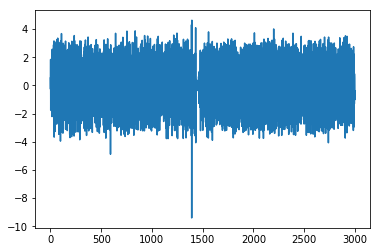

Wavlet Transfom  1


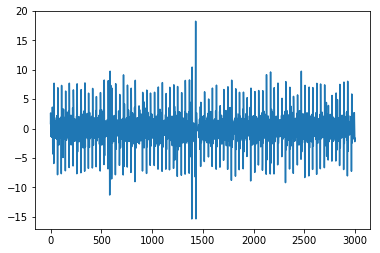

Wavlet Transfom  2


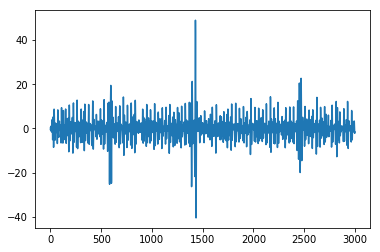

Wavlet Transfom  3


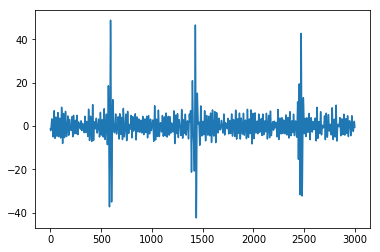

Wavlet Transfom  4


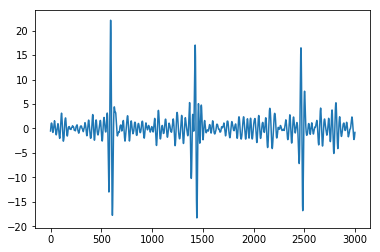

Wavlet Transfom  5


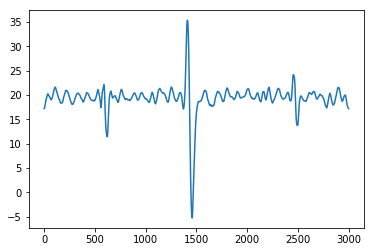

Filtered Signal


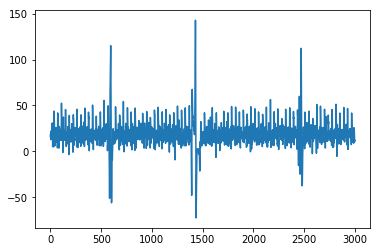

Raw Signal


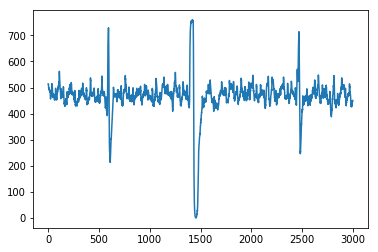

In [189]:
for i in range(len(wtmra)):
    print ("Wavlet Transfom ", i )
    plt.plot(wtmra[i])
    plt.show()    
print ("Filtered Signal")    
plt.plot(ecgd)
plt.show()
print ("Raw Signal")    
plt.plot(raw)
plt.show()

### 4. Test the R peaks function of biosppy ecg module

In [190]:
args = ecg.ecg(signal=df['Red_Signal'].values[minr:maxr], sampling_rate=100., show=False)

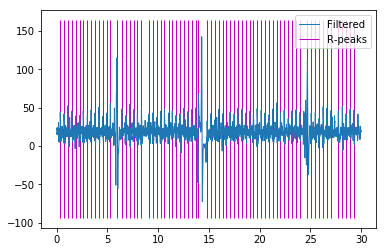

In [191]:
ts=args[0]
filtered=args[1]
rpeaks=args[2]
ymin = np.min(filtered)
ymax = np.max(filtered)
alpha = 0.1 * (ymax - ymin)
ymax += alpha
ymin -= alpha

plt.plot(ts, filtered, linewidth=1, label='Filtered')
plt.vlines(ts[rpeaks], ymin, ymax,
               color='m',
               linewidth=1,
               label='R-peaks')
plt.legend()
plt.show()

### Conclusions
The rpeaks calculated from this ecg module does not seem to work very on the gamer data.  It Failed on gamer 2 and 3 (Did not pickup any  r peaks). 

The filtered signal looks like it can be used with some Moving average type functions to detect the heart beats

Wavlet transform are unlikely to be useful
